<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter

## 1. Получение данных

In [456]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import pandas as pd
import pytz
import re
import requests
from forex_python.converter import CurrencyRates
from nltk.corpus import stopwords
import plotly.express as px
from wordcloud import WordCloud

In [457]:
# Решила не ограничивать запрос концом сентября, чтобы получить больше вакансий
MOSCOW_AREA_ID = 1


def getPage(page):
    params = {
        'area': MOSCOW_AREA_ID,
        'date_from': '2023-09-01T00:00:00',
        'page': page,
        'per_page': 100,
        'text': '(machine AND learning AND engineer) OR (data AND scientist)'
    }
    response = requests.get('https://api.hh.ru/vacancies', params)
    return response

response = getPage(0)
if response.status_code // 10 == 20:
    df = pd.DataFrame.from_dict(response.json()['items'])
    for page in range(1, response.json()['pages']):
        response = getPage(page)
        new_data = pd.DataFrame.from_dict(response.json()['items'])
        df = pd.concat([df, new_data], ignore_index=True)
else:
    print(f"Ошибка при получении вакансий. Код статуса: {response.status_code}")

## 2. Подготовка данных

In [458]:
df.head(3)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,adv_response_url,is_adv_vacancy,branding
0,86571284,False,"Data Scientist (стажер), удаленно",None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': None, 'to': 15000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,"[{'id': '96', 'name': 'Программист, разработчи...",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'probation', 'name': 'Стажировка'}",None,False,NaN
1,87786868,False,Junior Machine learning Engineer (remote),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 40000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': '3-й проезд Марьи...",...,[],[],False,"[{'id': '96', 'name': 'Программист, разработчи...",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",None,False,NaN
2,86620219,False,Бизнес-аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Каланчевская ули...",...,[],[],False,"[{'id': '150', 'name': 'Бизнес-аналитик'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",None,False,"{'type': 'MAKEUP', 'tariff': None}"


In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         413 non-null    object
 1   premium                    413 non-null    bool  
 2   name                       413 non-null    object
 3   department                 155 non-null    object
 4   has_test                   413 non-null    bool  
 5   response_letter_required   413 non-null    bool  
 6   area                       413 non-null    object
 7   salary                     46 non-null     object
 8   type                       413 non-null    object
 9   address                    155 non-null    object
 10  response_url               0 non-null      object
 11  sort_point_distance        0 non-null      object
 12  published_at               413 non-null    object
 13  created_at                 413 non-null    object
 14  archived  

Иммем датасет с 412 объявлениями и 36 признаками.

Признаки типов bool и object. В некоторых признаках отсутствует полезная информация (все значения null).

Посмотрим на признаки детальнее

In [460]:
df.describe()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,adv_response_url,is_adv_vacancy,branding
count,413,413,413,155,413,413,413,46,413,155,...,413,413,413,413,413,413,413,0,413,245
unique,413,2,327,35,2,2,1,36,1,124,...,2,2,2,26,2,4,4,0,1,2
top,86571284,False,Data Scientist,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': None, 'to': 350000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,[],[],False,"[{'id': '165', 'name': 'Дата-сайентист'}]",False,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,"{'type': 'MAKEUP', 'tariff': None}"
freq,1,412,30,42,401,408,413,4,413,8,...,409,409,397,157,405,219,399,NaN,413,236


Есть много признаков с данными в виде словаря или списка.

Можно автоматически развернуть их в колонки, но нам требуются не все ключи словарей для анализа, поэтому проанализируем и добавим колонки вручную.

Т.к. модель пока не планируем строить, бинарные признаки преобразовывать пока не будем.

In [461]:
# Есть колонки с данными в виде словарей. Нам не нужны все значения словарей,
# извлечем нужные
def get_fields_from_dict(column, fields):
    for field in fields:
        df[f'{column}_{field}'] = df[column].apply(lambda x: x if pd.isna(x) else x.get(field))

    df.drop([column], axis=1, inplace=True)

required_dict_fields = {
    'employer': ['name', 'accredited_it_employer', 'trusted'],
    'snippet': ['requirement', 'responsibility'],
    'branding': ['type'],
    'address':['city', 'lat', 'lng', 'metro'],
    'address_metro': ['station_name', 'lat', 'lng'],
    'department': ['name'],
    'experience': ['name'],
    'employment': ['name'],
    'schedule': ['name']
}
for column, keys in required_dict_fields.items():
    get_fields_from_dict(column, keys)

In [462]:
# По заработной плате очень мало данных, но мы все равно посмотрим на них
c = CurrencyRates()
exchange_rate = c.get_rates('RUB')

def get_salary(salary_dict):
    """Функция для грубого расчета ЗП в рублях за вычетом налога"""
    if not salary_dict:
        return salary_dict
    salary_from = salary_dict['from']
    salary_to = salary_dict['to']
    if salary_from and salary_to:
        salary = int((salary_from + salary_to)/2)
    else:
        salary = salary_from if salary_from else salary_to
    if salary_dict['currency'] != 'RUR':
        salary /= exchange_rate.get(salary_dict['currency'], 1)
    if salary_dict['gross'] == True:
        salary *= 0.87
    return salary

df['salary'] = df['salary'].apply(get_salary)

In [463]:
# Проверили, что в списке ролей во всех объявлениях только один элемент. Извлечем название
df['professional_role'] = df['professional_roles'].apply(lambda x: x if pd.isna(x) else x[0].get('name'))

# преобразуем колонки с датами к числовым значениям
# в колонках created_at и published_at идентичные данные
current_date = datetime.now(pytz.UTC)
df['days_since_created'] = (current_date - pd.to_datetime(df['created_at'])).dt.days
df.drop(['created_at', 'published_at'], axis=1, inplace=True)

# удалим колонки, где все значения NaN
columns_to_drop = [column for column in df.columns if len(df[column].value_counts()) == 0]
df.drop(columns_to_drop, axis=1, inplace=True)

# удалим архивные записи
df.drop(df[df['archived'] == True].index)

# удалим колонки данные которых нам не нужны для анализа (почти все значения пустые
# или которые содержат слишком много уникальных значений)
df.drop([
    'type', 'apply_alternate_url', 'url', 'alternate_url', 'insider_interview',
    'working_days', 'working_time_intervals', 'working_time_modes', 'relations',
    'archived', 'professional_roles', 'is_adv_vacancy', 'premium', 'area'
], axis=1, inplace=True)

In [464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               413 non-null    object 
 1   name                             413 non-null    object 
 2   has_test                         413 non-null    bool   
 3   response_letter_required         413 non-null    bool   
 4   salary                           46 non-null     float64
 5   show_logo_in_search              244 non-null    object 
 6   accept_temporary                 413 non-null    bool   
 7   accept_incomplete_resumes        413 non-null    bool   
 8   employer_name                    413 non-null    object 
 9   employer_accredited_it_employer  413 non-null    bool   
 10  employer_trusted                 413 non-null    bool   
 11  snippet_requirement              413 non-null    object 
 12  snippet_responsibility

Оставили 25 колонок. Некоторые из них все еще содержат null. Не будем заполнять пропущенные значения, т.к. не планируем строить модель.

In [465]:
df.describe()

,salary,address_lat,address_lng,address_metro_lat,address_metro_lng,days_since_created
count,46.000000,150.000000,150.000000,118.000000,118.000000,413.000000
mean,244295.835652,55.470309,37.820299,55.749070,37.955414,10.079903
std,111929.087702,2.410928,3.739602,0.080108,4.175188,8.583451
min,15000.000000,34.701631,33.046594,55.029941,37.440760,0.000000
25%,171475.000000,55.735926,37.531956,55.729974,37.534100,2.000000
50%,245000.000000,55.747809,37.567724,55.749100,37.562271,8.000000
75%,341000.000000,55.777550,37.629057,55.776819,37.620410,17.000000
max,548100.000000,55.928300,82.917842,55.953419,82.920690,29.000000


In [466]:
df.describe(exclude=[float, int])

,id,name,has_test,response_letter_required,show_logo_in_search,accept_temporary,accept_incomplete_resumes,employer_name,employer_accredited_it_employer,employer_trusted,snippet_requirement,snippet_responsibility,branding_type,address_city,address_metro_station_name,department_name,experience_name,employment_name,schedule_name,professional_role
count,413,413,413,413,244,413,413,413,413,413,413,411,245,150,118,155,413,413,413,413
unique,413,327,2,2,1,2,2,195,2,2,398,390,2,6,53,34,4,4,4,26
top,86571284,Data Scientist,False,False,True,False,False,СБЕР,False,True,Опыт работы как минимум с 2 ML библиотеками: S...,Развитие классических скоринговых моделей. Пос...,MAKEUP,Москва,Кутузовская,Сбер для экспертов,От 3 до 6 лет,Полная занятость,Полный день,Дата-сайентист
freq,1,30,401,408,244,397,405,74,342,410,3,3,236,145,17,42,219,399,291,157


## 3. Анализ данных

In [467]:
def create_bar(data, x, y, title):
    fig = px.bar(
        data_frame=data.sort_values(by=y, ascending=False),
        x=x,
        y=y,
        title=title,
        color=x,
        color_discrete_sequence=px.colors.qualitative.Bold,
    )
    fig.show()

In [468]:
data = df.groupby('employer_name', as_index=False)['id'].count().sort_values(by='id', ascending=False)[:10]
create_bar(data, 'employer_name', 'id', 'Топ-10 работодателей по количеству вакансий')

СБЕР лидирует по количеству искомых вакансий - 74. Следующие за ним 9 компаний даже суммарно не предоставляют такое же количество вакансий (67).

In [469]:
data = df.groupby('employer_accredited_it_employer', as_index=False)['id'].count()
create_bar(data, 'employer_accredited_it_employer', 'id', 'Количество вакансий и аккредитация работодателей')

Интересно, что у 83% работодателей нет IT-аккредитации.

Попробуем поискать топ более безопасных работодателей по количеству вакансий

In [470]:
data = df[df['employer_accredited_it_employer'] == True]
data = data.groupby('employer_name', as_index=False)['id'].count().sort_values(by='id', ascending=False)[:10]
create_bar(data, 'employer_name', 'id', 'Топ-10 работодателей по количеству вакансий')

Интересно, что сюда не попал СБЕР, хотя он является аккредитованной IT-компанией. Либо в вакансиях неверные данные, либо в каких-то департаментах СБЕРа какая-то особая ситуация с аккредитацией.

In [471]:
def create_wordcloud(column):
    text = ' '.join(df[~pd.isna(df[column])][column])
    text = re.sub(r'[^\w\s]', '', text.lower())
    words = text.split()
    stop_words = set(stopwords.words('russian'))
    filtered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    filtered_text = filtered_text.replace('highlighttext', '')

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

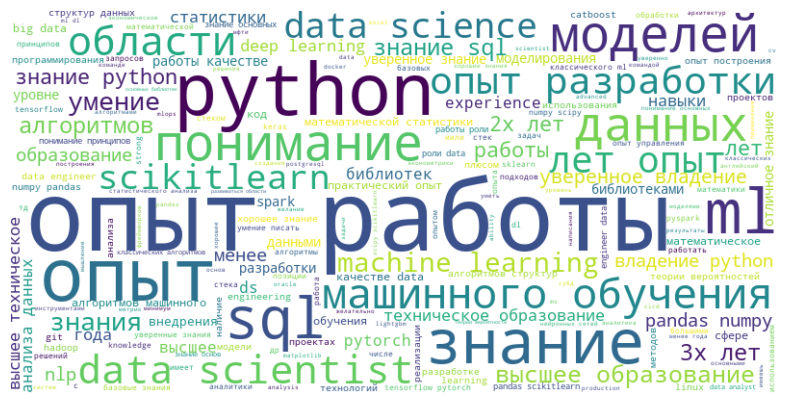

In [472]:
create_wordcloud('snippet_requirement')

Для полноценного анализа требований и обязанностей кандидатов стоило бы разделить вакансии на ML и DS.

Однако т.к. мы искали вакансии по вхождению ML и DS не только в заголовке, но и в теле вакансии, то некоторые вакансии пересекаются. В рамках текущей задачи не будем придумывать оптимальные критерии разбиения, проанализируем в общем.

Опыт работы является одним из первоочередных требований и встречается даже чаще, чем python или другие популярные требования.Видим, что среди навыков чаще всего требуются SQL, ML, Python. Pandas, Numpy, deep learning, nlp и другие навыки упоминаются гораздо реже. Также часто требуется наличие образования.

Проверим информацию о требуемом опыте

In [473]:
data = df.groupby('experience_name', as_index=False)['id'].count()
create_bar(data, 'experience_name', 'id', 'Количество вакансий в зависимости от требуемого опыта')

Действительно, кандидатов без опыта готовы рассматривать только в 15 вакансиях.

А более, чем в половине вакансий требуется опыт от 3 до 6 лет. Т.о. вход в DS и ML для кандидатов без опыта довольно сложен.

In [474]:
def get_expierence(experience_name):
    experience_dict = {
        'Нет опыта': 0,
        'От 1 года до 3 лет': 1,
        'От 3 до 6 лет': 2,
        'Более 6 лет': 3
    }
    return experience_dict.get(experience_name)

df['expierence'] = df['experience_name'].apply(get_expierence)
fig = px.scatter(
    data_frame=df[~pd.isna(df['salary'])],
    x = 'salary',
    y = 'expierence',
    width=1000,
    height=700,
    title='Взаимосвязь зарплаты и требуемого опыта работы',
    labels = {'salary': 'ЗП', 'expierence': 'Требуемый опыт'}
)
fig.add_scatter(
    x=[0, 400000],
    y=[0, 3],
    mode='lines',
    showlegend=False
)
fig.show()

Как видим, прослеживается зависимость ЗП от требуемого опыта.

ЗП кандидатов с опытом от 3х лет начинается от 200 тысяч

Но мы помним, что данных о ЗП очень мало, и эти данные содержат выбросы.

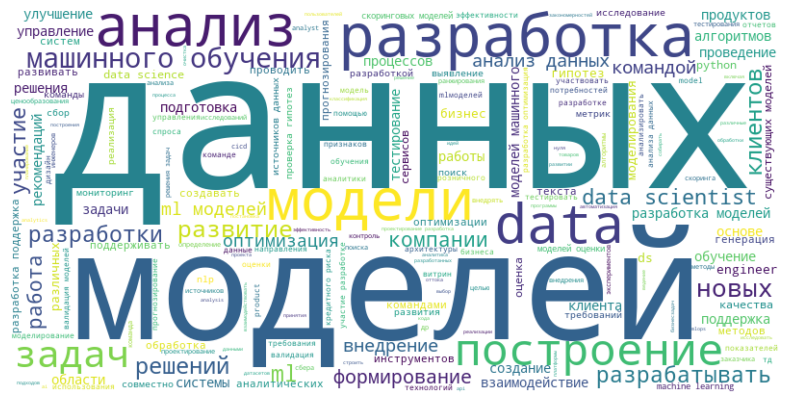

In [475]:
create_wordcloud('snippet_responsibility')

Среди обязанностей предсказуемо чаще всего встречаются общие фразы про анализ данных, разработку/построение моделей машинного обучения.

Необходимость управления командой, обучения, внедрения моделей и прочее встречаются гораздо реже.

In [476]:
fig = px.histogram(
    data_frame=df,
    x='salary',
    title='Распределение заработной платы',
    marginal='box',
    width=1000
)
fig.show()

Данных по заработной плате очень мало для полноценного анализа. Работодатели предпочитают не указывать суммы в таких вакансиях.

По тем немногочисленным данным, что имеем, можно сказать, что большинство ЗП лежит в интервале от 120 до 360 тыс.

Есть некоторые выбросы, от которых при полноценном анализе стоило бы избавиться. Например, ниже приведены вакансия DS стажера на полный день за 15000 и вакансия ML-сеньора в международную фирму на удаленку. Обе эти вакансии вполне могут быть правдой, но могут исказить данные.

In [477]:
df[(df['salary']==15000)|(df['salary']>500000)][['name', 'salary', 'employer_name', 'employment_name']]

,name,salary,employer_name,employment_name
0,"Data Scientist (стажер), удаленно",15000.0,Дунаев Михаил Алексеевич,Стажировка
51,Senior Python / Machine Learning Engineer,548100.0,AINAUTS LLC,Полная занятость


In [478]:
# построим гистограмму распределения срока давности вакансии
fig = px.histogram(
    data_frame=df,
    x='days_since_created',
    title='Распределение срока давности вакансии',
    marginal='box',
    width=1000,
    nbins=30
)
fig.show()

Как видим, новых вакансий гораздо больше, чем старых. Видимо, компании достаточно быстро находят нужных кандидатов. 

Также на графике видно, что еженедельно в количестве вакансий есть спады - в воскресенье работодатели практически не выкладывают вакансии.

In [479]:
data = df.groupby('schedule_name', as_index=False)['id'].count()
create_bar(data, 'schedule_name', 'id', 'Количество вакансий в зависимости от графика')

In [480]:
data = df.groupby('employment_name', as_index=False)['id'].count()
create_bar(data, 'employment_name', 'id', 'Количество вакансий в зависимости от вида занятости')

Видим, что работодатели предпочитают, чтобы сотрудники работали в офисе полный день. Удаленная работа предполагается только в четверти вакансий. Возможно, это связано с тем, что работодатели постепенно отказываются от удаленки в связи с более низкой эффективностью такой работы. Также практически отсутствуют вакансии, предлагающие частичную занятость или стажировку, которые могли бы подойти студентам.

#### Дальнейшие возможности для анализа:
- Осталось много непроанализированных колонок. Если бы данных о заработной плате было больше, интересно было бы проанализировать заработную плату в зависимости от различных параметров;
- Можно проанализировать местоположение работодателей и близость к метро (знаем координаты места работы и координаты ближайшего метро);
- Можно детальнее проанализировать текстовые поля с требованиями и обязанностями, проанализировать зависимость уровня ЗП от конкретных навыков;

## 4. Выгрузка данных

In [481]:
file_name = f'{os.getcwd()}/hh_data.csv'
df.to_csv(file_name)